# Sentiment Classification Using Logistic Regression

For this project, I will be implementing a naive bayes baseline classifier. Additionally, I will be using pytorch to implement a binary logistic regression classifier. The task is sentiment classification for hotel reviews. The input to the model will be a text review, and the output label is a 1 or 0 marking it as positive or negative.

In [1]:
import numpy as np
import random
import torch
from util import *

## Section 1: Sentiment Classification Dataset Exploration

The training data for this task consists of a collection of short hotel reviews. The data is formatted as one review per line. Each line starts with a unique identifier for the review (as in ID-2001) followed by tab and the text of the review.  The reviews are not tokenized or sentence segmented in any way (the words are space separated). The positive reviews and negative reviews appear in separate files namely [hotelPosT-train.txt](data/hotelPosT-train.txt) and [hotelNegT-train.txt](data/hotelNegT-train.txt).

In [2]:
# load the dataset
pos_datapath = "data/hotelPosT-train.txt"
neg_datapath = "data/hotelNegT-train.txt"
all_texts, all_labels = load_train_data(pos_datapath, neg_datapath)


### Let's look at what is in the data

In [4]:
# print positive and negative examples from all_texts
def random_sample(texts, labels, label):
    data_by_label = {}
    for lab, text in zip(labels, texts):
        if lab not in data_by_label:
            data_by_label[lab] = []
        data_by_label[lab].append(text)
    return random.choice(data_by_label[label])

print("--- Positive Example ---")
print(random_sample(all_texts, all_labels, label=1))
print("\n--- Negative Example ---")
print(random_sample(all_texts, all_labels, label=0))


--- Positive Example ---
This hotel was fantastic, everything about it was simply amazing. Not only that, but on my first attempt to find the place, my GPS took me to the wrong location (another Hyatt Place) and even THAT location was clean, and had nice attendants who promptly directed me to the other location.  The price and amenities are simply unbeatable. Due to extending my stay, I had to switch hotels, and let me say, this hotel offered twice the value at half the cost. When you enter, the room is split into multiple rooms, the TV is huge and HD, the WiFi is free, and the beds are so comfortable. Downstairs, they have a 24/7 desert bar, you simply walk down, tell them what you want, and they add it to your tab (they don't even ask for your room number, they remember it!). So convenient and amazing. When you show up, they even offer you a personalized tour!  And when you wake up, stop by the breakfast. Their biscuits and gravy are to die for.

--- Negative Example ---
The Rio hote

### Test Data

This is the test dataset that I will use to report the results on. This set is the unseen dataset.

In [6]:
# Load the test data

test_datapath = "./data/HW2-testset.txt"
test_texts, test_labels = load_test_data(test_datapath)


### Task 1.1: Print the number of "positive" and "negative" samples

It is important to know the distribution of the training examples. More often than not, we will have to work with datasets that are not "balanced" with respect to the labels of the samples. For this task, let us print out the number of examples that have label = 1 and label = 0, respectively, in std:out or plot a pie chart.

In [7]:
def label_distribution(labels):
    """
    TODO: Replace the line `raise NotImplementedError` with your code
    to print the labels distribution.
    
    Args:
        labels (List[int]): Labels for the dataset. 1 = postive, 0 = negative
    
    Returns
        pos_count, neg_count (int, int): The counts of each label
    """
    # raise NotImplementedError
    pos_labels = [label for label in labels if label == 1]
    neg_labels = [label for label in labels if label == 0]

    return len(pos_labels), len(neg_labels)

label_distribution(all_labels)

(95, 94)

### Task 1.2: Split Training and Development Sets

For the purpose of coming with the best parameters for the model we will have to split the dataset into training and development sets. Make sure the splits follow the same distribution.

In [8]:
from sklearn.model_selection import train_test_split

def split_dataset(texts, labels):
    """
    Split the dataset randomly into 80% training and 20% development set.
    Ensure the splits have the same label distribution using stratification.
    """
    train_texts, dev_texts, train_labels, dev_labels = train_test_split(
        texts, labels, test_size=0.2, stratify=labels, random_state=42
    )
    return train_texts, train_labels, dev_texts, dev_labels

# Example usage
train_texts, train_labels, dev_texts, dev_labels = split_dataset(all_texts, all_labels)

In [9]:
print("len_train_labels", len(train_labels))
print("len_test_labels", len(dev_labels))

len_train_labels 151
len_test_labels 38


In [10]:
print('Train Label Distribution:')
print('Train Label Distribution:', label_distribution(train_labels))

print('Dev Label Distribution:')
print('Dev Label Distribution:', label_distribution(dev_labels))

Train Label Distribution:
Train Label Distribution: (76, 75)
Dev Label Distribution:
Dev Label Distribution: (19, 19)


### Task 1.3: Evaluation Metrics

Implement the evaulation metrics: Accuracy, Precision, Recall and F1 score

In [11]:
def accuracy(predicted_labels, true_labels):
    """
    Accuracy is correct predictions / all predicitons
    """
    correct_predictions = sum(p == t for p, t in zip(predicted_labels, true_labels))
    total_predictions = len(true_labels)
    return correct_predictions / total_predictions #if total_predictions > 0 else 0
    # raise NotImplementedError

def precision(predicted_labels, true_labels):
    """
    Precision is True Positives / All Positives Predictions
    Args:
    predicted_labels (list or array): List or array of predicted labels (1 for positive, 0 for negative).
    true_labels (list or array): List or array of true labels (1 for positive, 0 for negative).
    
    Returns:
    float: Precision score.
    """
    true_positives = 0
    false_positives = 0
    
    for pred, true in zip(predicted_labels, true_labels):
        if pred == 1 and true == 1:
            true_positives += 1
        elif pred == 1 and true == 0:
            false_positives += 1
    
    # if true_positives + false_positives == 0:
    #     return 0.0  # Avoid division by zero
    
    return true_positives / (true_positives + false_positives)

    # raise NotImplementedError

def recall(predicted_labels, true_labels):
    """
    Recall is True Positives / All Positive Labels
    """
    true_positives = 0
    false_negatives = 0
    
    for pred, true in zip(predicted_labels, true_labels):
        if pred == 1 and true == 1:
            true_positives += 1
        elif pred == 0 and true == 1:
            false_negatives += 1
    
    # if true_positives + false_positives == 0:
    #     return 0.0  # Avoid division by zero
    
    return true_positives / (true_positives + false_negatives)
    # raise NotImplementedError

def f1_score(predicted_labels, true_labels):
    """
    F1 score is the harmonic mean of precision and recall
    """
    precision_val = precision(predicted_labels, true_labels)
    recall_val = recall(predicted_labels, true_labels)

    return 2 * (precision_val * recall_val) / (precision_val + recall_val)
    # raise NotImplementedError

In [12]:
### DO NOT EDIT ###

em_test_labels = [0]*6 + [1]*4
em_test_predictions = [0]*8 + [1]*2

em_test_accuracy = 0.8
em_test_precision = 1.0
em_test_recall = 0.5
em_test_f1 = 2/3

assert accuracy(em_test_predictions, em_test_labels) == em_test_accuracy
assert precision(em_test_predictions, em_test_labels) == em_test_precision 
assert recall(em_test_predictions, em_test_labels) == em_test_recall
assert f1_score(em_test_predictions, em_test_labels) == em_test_f1

print('All Test Cases Passed!')

All Test Cases Passed!


## Section 2: Baselines

It is important to come up with baselines for the classifications to compare the more complicated models with. The baselines are also useful as a debugging method for our actual classfication model. I will create two baselines:

1. Random Chance
2. Naive Bayes Classifier

### Task 2.1: Random Chance Classifier

A random chance classifier predicts the label according to the label's distribution. As an example, if the label 1 appears 70% of the times in the training set, you predict 70 out of 100 times the label 1 and label 0 30% of the times

In [13]:
def predict_random(train_labels, num_samples):
    """
    Using the label distribution, predict the label num_sample number of times

    Predicts the label num_samples times based on the distribution of labels in train_labels.
    
    Args:
    train_labels (list or array): List or array of true labels.
    num_samples (int): The number of predictions to generate.
    
    Returns:
    np.array: Predicted labels based on the distribution.
    """
    # Calculate the distribution of labels
    unique_labels, counts = np.unique(train_labels, return_counts=True)
    probabilities = counts / len(train_labels)  # Get the probability of each label
    # print("probabilities: ", probabilities)
    # Predict labels according to the calculated probabilities
    predictions = np.random.choice(unique_labels, size=num_samples, p=probabilities)
    
    return predictions
    # raise NotImplementedError

In [14]:
rc_labels = np.array([1]*10 + [0]*5, dtype=int)
rc_predictions = predict_random(rc_labels, 3)
assert len(rc_predictions) == 3
assert len(set(rc_predictions).difference({0, 1})) == 0

rc_labels = np.array([0]*10 + [1]*5, dtype=int)
rc_predictions = predict_random(rc_labels, 100)
p, n = label_distribution(rc_predictions)
assert n > p

rc_labels = np.array([1]*10 + [0]*5, dtype=int)
rc_predictions = predict_random(rc_labels, 100)
p, n = label_distribution(rc_predictions)
assert p > n

print('All Test Cases Passed!')

All Test Cases Passed!


### Task 2.2: Naive Bayes Classifier

In this task, I will implement a Naive Bayes Classifier using the tokens in the training sample. As a preprocessing step, I will tokenize via whitespace separation and lowercase all tokens.

### Task 2.2.2: Preprocessing

Tokenize text by separating by whitespace, and then lowercase all tokens.

In [15]:
def preprocess(text):
    """
    Takes a string of text and returns a list of the whitespace-separated and lowercased tokens.
    """
    tokens = text.lower().split()
    # You might wanna remove stop words.
    return tokens
    # raise NotImplementedError
    
test_string = "This sentence needs to be preprocessed."

assert preprocess(test_string) == ['this', 'sentence', 'needs', 'to', 'be', 'preprocessed.']

print('All Test Cases Passed!')

All Test Cases Passed!


### Task 2.2.3: The Naive Bayes Class

The standard way of implementing classifiers like Naive Bayes is to implement the two methods: "fit" and "predict". The fit method expects the training data along with labels, and the predict method predicts the labels for the provides texts of samples.

In [16]:
import numpy as np
from collections import defaultdict, Counter
import re

class NaiveBayesClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.label_word_counter = defaultdict(Counter)
        self.label_words_count = defaultdict(int)
        self.label_count = defaultdict(int)
        self.vocabulary = set()

    # def preprocess(self, text):
    #     # Simple text preprocessing: lowercasing and removing non-alphanumeric characters
    #     return re.findall(r'\b\w+\b', text.lower())

    def fit(self, texts, labels):
        """
        1. Group samples by their labels
        2. Preprocess each text
        3. Count the words of the text for each label
        """
        for text, label in zip(texts, labels):
            words = preprocess(text)
            self.vocabulary.update(words)
            self.label_count[label] += 1
            self.label_words_count[label] += len(words)
            self.label_word_counter[label].update(words)

    def predict(self, texts):
        """
        1. Preprocess the texts
        2. Predict the class by using the likelihood with Bayes Method and Laplace Smoothing
        """
        predictions = []
        vocab_size = len(self.vocabulary)
        total_docs = sum(self.label_count.values())

        for text in texts:
            words = preprocess(text)
            label_probs = {}

            for label in range(self.num_classes):
                # Log prior probability
                log_prob = np.log(self.label_count[label] / total_docs)

                # Log likelihood with Laplace smoothing
                for word in words:
                    word_count = self.label_word_counter[label][word] + 1  # Laplace smoothing
                    word_prob = word_count / (self.label_words_count[label] + vocab_size)
                    log_prob += np.log(word_prob)

                label_probs[label] = log_prob

            # Choose the label with the highest probability
            predictions.append(max(label_probs, key=label_probs.get))

        return predictions
    

### Task 2.3: Baseline Results

Since there is not hyperparameter-tuing required for the baselines, we can use the entirety of the training set (no need to split the dataset into train and development).

In [17]:
### DO NOT EDIT ###

### DEV SET RESULTS

testset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, dev_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(train_texts, train_labels)
testset_predictions_nb = naive_bayes_classifier.predict(dev_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, dev_labels))

Random Chance F1: 0.5
Naive Bayes F1: 0.8717948717948718


In [18]:
### DO NOT EDIT ###
### TEST SET RESULTS

testset_prediction_random = predict_random(all_labels, num_samples=len(test_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, test_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(all_texts, all_labels)
testset_predictions_nb = naive_bayes_classifier.predict(test_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, test_labels))

Random Chance F1: 0.3673469387755102
Naive Bayes F1: 0.8627450980392156


## Section 3: Logistic Regression on Features

Now let's try building a logistic regression based classifier on hand-engineered features.

The following tasks are going to be the implementation of the components required in building a Logistic Regressor.

### Task 3.0: Feature Extraction

This is perhaps the most challenging part of this project. 

This task requires a thorough understanding of the dataset to answer the important question, "What is in the data?". For this, we need to go through some of the datapoints and convert the signals that we think might help in identifying "sentiment" as features.

Please use the files with postive and negative words attached in the assignment: [positive_words.txt](data/poisitive-words.txt) and  [negative_words.txt](data/negative-words.txt)

In [19]:
def make_test_feature(text):
    return "happy" in text
# Read the text file and store each word in a list
def read_words_from_file(filename):
    with open(filename, 'r') as file:
        words = [line.strip() for line in file.readlines()]
    return words
def count_positive_negative_words(text):

    positive_words = read_words_from_file("./data/positive-words.txt")
    negative_words = read_words_from_file("./data/negative-words.txt")
    # print()
    positive_count = sum(1 for word in text if word in positive_words)
    negative_count = sum(1 for word in text if word in negative_words)

    # positive_count = sum(1 for word in text.lower().split() if word in positive_words)
    # negative_count = sum(1 for word in text.lower().split() if word in negative_words)
    return positive_count, negative_count
# Feature: Length of the review (number of words)
def review_length(text):
    # print("text: ", text)
    # print("text type: ", type(text))
    return len(text)

# Feature: Count of exclamation marks (could indicate strong emotion)
def count_exclamations(text):
    return sum(part.count("!") for part in text)

def extract_features(text):
    features = []
    # TODO: Replace this with your own feature extraction functions.
    
    # Add individual features to the feature list
    features.append(make_test_feature(text))
    # print("text: ", text)
    features.append(review_length(text))
    features.append(count_exclamations(text))
    # features.append(sentiment_polarity(text))
    # features.append(has_negation(text))
    
    # Positive/Negative word count
    pos_count, neg_count = count_positive_negative_words(text)
    features.append(pos_count)
    features.append(neg_count)
    # TODO: add more features to the feature vector
    
    return features

In [20]:
train_texts[0]

'My wife, two-year old son and I stayed at La Quinta Inn in Garland, Texas during our vacation this Spring Break. The staff was very nice and accomodating. They quickly brought up a crib for our son soon after we requested one. The room was clean and very spacious. Our bed was also comfortable. A great breakfast came free with the stay. They offered scrambled eggs, waffles, cereals, pastries, and much more. We had a great stay here. It only cost us about $80 a night.'

In [21]:
### DO NOT CHANGE THE SIGNATURE OF THE function THOUGH ###

def featurize_data(texts, labels):
    features = [
        extract_features(preprocess(text)) for text in texts
    ]
    return torch.FloatTensor(features), torch.FloatTensor(labels)

# train_features, train_labels_tensor = featurize_data(train_texts, train_labels)

In [22]:
# train_features

### Task 3.0.2: Feature Scaling

In this task we will use the data normalization technique to ensure the scales of the feature are consistent.
After featurizing the dataset, we need to call the following function before passing it to the classifier

#### Normalization Formula

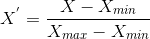

In [23]:
def normalize(features: torch.Tensor) -> torch.Tensor:
    """
    return the features transformed by the above formula of normalization
    """
        # Compute the minimum and maximum values along the feature dimension (dim=0)
    x_min = features.min(dim=0, keepdim=True).values
    x_max = features.max(dim=0, keepdim=True).values
    
    # Normalize the features
    normalized_features = (features - x_min) / (x_max - x_min + 1e-8)  # Adding epsilon to avoid division by zero
    
    return normalized_features
    # raise NotImplementedError

## Training a Logistic Regression Classifier

In this section, I will implement the components needed to train the binary classifier using logistic regression

### Here we define our pytorch logistic regression classifier (DO NOT EDIT THIS)

In [24]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        # We force output to be one, since we are doing binary logistic regression
        self.output_size = 1
        self.coefficients = torch.nn.Linear(input_dim, self.output_size)
        # Initialize weights. Note that this is not strictly necessary,
        # but you should test different initializations per lecture
        initialize_weights(self.coefficients)
        
    def forward(self, features: torch.Tensor):
        # We predict a number by multipling by the coefficients
        # and then take the sigmoid to turn the score as logits
        return torch.sigmoid(self.coefficients(features))

### Task 3.1: Initialize the weights.

Initialization of the parameters is an important step to ensure the SGD algorithm converges to a global optimum. Typically, we need to try different initialization methods and compare the accuracy we achieve for the development set. In this task, implement the function that initializes the parameters to ones.

In [25]:
import torch.nn as nn
def initialize_weights(coefficients):
    """
    TODO: Replace the line `raise NotImplementedError` with your code.
    Initialize the weights of the coefficients by assigning the parameter
    coefficients.weights.data = ...
    """
    # Set all weights to 1.0
    coefficients.weight.data.fill_(1.0)
    
    # Optionally, set bias to 0.0 if needed
    if coefficients.bias is not None:
        coefficients.bias.data.fill_(0.0)

In [26]:
test_module = torch.nn.Linear(5, 1)
initialize_weights(test_module)
assert test_module.weight.ravel().tolist() == [1.0, 1.0, 1.0, 1.0, 1.0]

print('All Test Cases Passed!')

All Test Cases Passed!


Fill in the loss function by implementing binary cross-entropy loss between the prediction and label. As a reminder, binary cross-entropy loss between the prediction y_hat and the target y, averaged over N examples, is:

![loss.png](attachment:loss.png)

### Task 3.2: Logistic Loss Function

In [27]:
def logistic_loss(prediction: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    """
    TODO: Implement the logistic loss function between a prediction and label.
    """
    # To prevent log(0) issues, we clamp predictions between a small epsilon and 1-epsilon
    eps = 1e-7
    prediction = torch.clamp(prediction, eps, 1 - eps)
    # print("prediction: ", prediction)
    # print("torch.log(1 - prediction):", torch.log(1 - prediction))
    # print("torch.log(prediction):", torch.log(prediction))
    loss = - (label * torch.log(prediction) + (1 - label) * torch.log(1 - prediction))
    
    # Return the mean loss over all samples
    return loss.mean()
    

### Task 3.3: Create an SGD optimizer

In [30]:
def make_optimizer(model, learning_rate) -> torch.optim:
    """
    Returns an Stocastic Gradient Descent Optimizer
    See here for algorithms you can import: https://pytorch.org/docs/stable/optim.html
    """
    return torch.optim.Adam(model.parameters(), learning_rate)
    # return torch.optim.SGD(model.parameters(), learning_rate)

### Task 3.5: Converting Logits into Predictions

In [31]:
def predict(model, features):
    with torch.no_grad():
        """
        TODO: Replace the line `raise NotImplementedError`
        with the logic of converting the logits into prediction labels (0, 1)
        """
        logits = model(features)
        logits = torch.squeeze(logits)
        predictions = (logits >= 0.5).float()
        return predictions
        # raise NotImplementedError

### Training Function (DO NOT EDIT THIS)

In [32]:
from tqdm.autonotebook import tqdm
import random


def training_loop(
    num_epochs,
    batch_size,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model
):
    samples = list(zip(train_features, train_labels))
    random.shuffle(samples)
    batches = []
    for i in range(0, len(samples), batch_size):
        batches.append(samples[i:i+batch_size])
    print("Training...")
    for i in range(num_epochs):
        losses = []
        for batch in tqdm(batches):
            # Empty the dynamic computation graph
            features, labels = zip(*batch)
            features = torch.stack(features)
            labels = torch.stack(labels)
            optimizer.zero_grad()
            # Run the model
            logits = model(features)
            # Compute loss
            loss = logistic_loss(torch.squeeze(logits), labels)
            # In this logistic regression example,
            # this entails computing a single gradient
            loss.backward()
            # Backpropogate the loss through our model
            # Update our coefficients in the direction of the gradient.
            optimizer.step()
             # For logging
            losses.append(loss.item())
        
        # Estimate the f1 score for the development set
        dev_f1 = f1_score(predict(model, dev_features), dev_labels)
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print(f"Dev F1 {dev_f1}")
        
    # Return the trained model
    return model

/var/folders/25/rlbty0wj62qgtp38sml170rr0000gn/T/ipykernel_4308/3686070062.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Task 3.6: Train the classifier

Run the following cell to train a logistic regressor on your hand-engineered features.

In [33]:
num_epochs = 30

train_features, train_labels_tensor = featurize_data(train_texts, train_labels)
train_features = normalize(train_features)
dev_features, dev_labels_tensor = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
model = SentimentClassifier(train_features.shape[1]) 
optimizer = make_optimizer(model, learning_rate=0.01)

trained_model = training_loop(
    num_epochs,
    16,
    train_features,
    train_labels_tensor,
    dev_features,
    dev_labels_tensor,
    optimizer,
    model
)

Training...


100%|██████████| 10/10 [00:00<00:00, 767.12it/s]


epoch 0, loss: 0.7785831570625306
Dev F1 0.6785714285714285


100%|██████████| 10/10 [00:00<00:00, 2550.50it/s]


epoch 1, loss: 0.7531282365322113
Dev F1 0.6545454545454545


100%|██████████| 10/10 [00:00<00:00, 5923.32it/s]


epoch 2, loss: 0.7321554958820343
Dev F1 0.6415094339622641


100%|██████████| 10/10 [00:00<00:00, 4585.44it/s]


epoch 3, loss: 0.7148058414459229
Dev F1 0.6415094339622641


100%|██████████| 10/10 [00:00<00:00, 2590.68it/s]


epoch 4, loss: 0.700419956445694
Dev F1 0.6538461538461537


100%|██████████| 10/10 [00:00<00:00, 4115.29it/s]


epoch 5, loss: 0.6882759511470795
Dev F1 0.6122448979591837


100%|██████████| 10/10 [00:00<00:00, 3024.01it/s]


epoch 6, loss: 0.677722442150116
Dev F1 0.625


100%|██████████| 10/10 [00:00<00:00, 5235.68it/s]


epoch 7, loss: 0.6682543873786926
Dev F1 0.625


100%|██████████| 10/10 [00:00<00:00, 5810.09it/s]


epoch 8, loss: 0.6595227420330048
Dev F1 0.6521739130434783


100%|██████████| 10/10 [00:00<00:00, 2346.86it/s]


epoch 9, loss: 0.6513064742088318
Dev F1 0.6818181818181819


100%|██████████| 10/10 [00:00<00:00, 5649.66it/s]


epoch 10, loss: 0.643473893404007
Dev F1 0.6976744186046512


100%|██████████| 10/10 [00:00<00:00, 2405.68it/s]


epoch 11, loss: 0.6359490275382995
Dev F1 0.7142857142857143


100%|██████████| 10/10 [00:00<00:00, 5754.29it/s]


epoch 12, loss: 0.6286877930164337
Dev F1 0.761904761904762


100%|██████████| 10/10 [00:00<00:00, 4478.22it/s]


epoch 13, loss: 0.6216635704040527
Dev F1 0.761904761904762


100%|██████████| 10/10 [00:00<00:00, 3533.24it/s]


epoch 14, loss: 0.6148590981960297
Dev F1 0.761904761904762


100%|██████████| 10/10 [00:00<00:00, 5227.20it/s]


epoch 15, loss: 0.6082619547843933
Dev F1 0.7804878048780488


100%|██████████| 10/10 [00:00<00:00, 5259.97it/s]


epoch 16, loss: 0.6018625557422638
Dev F1 0.7804878048780488


100%|██████████| 10/10 [00:00<00:00, 1732.18it/s]


epoch 17, loss: 0.5956528902053833
Dev F1 0.7804878048780488


100%|██████████| 10/10 [00:00<00:00, 5491.36it/s]


epoch 18, loss: 0.5896260201931
Dev F1 0.7804878048780488


100%|██████████| 10/10 [00:00<00:00, 3370.27it/s]


epoch 19, loss: 0.5837756276130677
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 5274.53it/s]


epoch 20, loss: 0.5780958712100983
Dev F1 0.8


100%|██████████| 10/10 [00:00<00:00, 5942.62it/s]


epoch 21, loss: 0.572581273317337
Dev F1 0.8205128205128205


100%|██████████| 10/10 [00:00<00:00, 3774.91it/s]


epoch 22, loss: 0.5672265589237213
Dev F1 0.8205128205128205


100%|██████████| 10/10 [00:00<00:00, 5426.01it/s]


epoch 23, loss: 0.5620267182588577
Dev F1 0.8421052631578947


100%|██████████| 10/10 [00:00<00:00, 4745.76it/s]


epoch 24, loss: 0.5569768726825715
Dev F1 0.8648648648648649


100%|██████████| 10/10 [00:00<00:00, 2513.21it/s]


epoch 25, loss: 0.552072262763977
Dev F1 0.8648648648648649


100%|██████████| 10/10 [00:00<00:00, 5643.57it/s]


epoch 26, loss: 0.5473083138465882
Dev F1 0.918918918918919


100%|██████████| 10/10 [00:00<00:00, 3032.98it/s]


epoch 27, loss: 0.5426805883646011
Dev F1 0.918918918918919


100%|██████████| 10/10 [00:00<00:00, 5459.20it/s]


epoch 28, loss: 0.5381846964359284
Dev F1 0.8947368421052632


100%|██████████| 10/10 [00:00<00:00, 6090.18it/s]

epoch 29, loss: 0.5338164657354355
Dev F1 0.8947368421052632


### Task 3.7: Get the predictions on the Test Set using the Trained model and print the F1 score

In [34]:
### DEV SET RESULTS

train_texts, train_labels, dev_texts, dev_labels = split_dataset(all_texts, all_labels)

devset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
dev_random_f1 = f1_score(devset_prediction_random, dev_labels)
print('Random Chance F1:', dev_random_f1)

assert dev_random_f1 > 0

print('All Test Cases Passed!')

Random Chance F1: 0.4878048780487805
All Test Cases Passed!


In [35]:
### DEV SET RESULTS - LOGISTIC REGRESSION

dev_features, dev_labels = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
dev_logistic_accuracy = accuracy(predict(trained_model, dev_features), dev_labels.tolist())
dev_logistic_f1 = f1_score(predict(trained_model, dev_features), dev_labels.tolist())
print('Logistic Regression Results:')
print('Accuracy:', dev_logistic_accuracy)
print('F1-score', dev_logistic_f1)

Logistic Regression Results:
Accuracy: tensor(0.8947)
F1-score 0.8947368421052632


In [36]:
### TEST SET RESULTS - RANDOM CHANCE
### DO NOT EDIT ###

# load the test data
test_datapath = "data/HW2-testset.txt"
test_texts, test_labels = load_test_data(test_datapath)

testset_prediction_random = predict_random(all_labels, num_samples=len(test_labels))
test_random_f1 = f1_score(testset_prediction_random, test_labels)
print('Random Chance F1:', test_random_f1)
testset_prediction_naive = naive_bayes_classifier.predict(test_texts)
test_naive_f1 = f1_score(testset_prediction_naive, test_labels)
print('Naive Bayes F1:', test_naive_f1)

Random Chance F1: 0.6274509803921569
Naive Bayes F1: 0.8627450980392156


In [37]:
### DO NOT EDIT ###
### TEST SET RESULTS

# load the test data
test_datapath = "data/HW2-testset.txt"
test_texts, test_labels = load_test_data(test_datapath)

test_features, test_labels = featurize_data(test_texts, test_labels)
test_features = normalize(test_features)
test_logistic_accuracy = accuracy(predict(trained_model, test_features), test_labels.tolist())
test_logistic_f1 = f1_score(predict(trained_model, test_features), test_labels.tolist())
print('Logistic Regression Results:')
print('Accuracy:', test_logistic_accuracy)
print('F1-score', test_logistic_f1)

Logistic Regression Results:
Accuracy: tensor(0.8000)
F1-score 0.8333333333333333
